In [1]:
from tqdm.autonotebook import tqdm
import torch
import pytorch_lightning as pl
import resnet
import os
import numpy as np



INIT_LR = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
selected_model = "trans/savedaugtrans"
classes = ['no','sphere','vort']

def get_prediction(x, model):
  model.freeze() # prepares model for predicting
  probabilities = torch.softmax(model(x), dim=1)
  predicted_class = torch.argmax(probabilities, dim=1)
  return predicted_class, probabilities

class LensTestDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, u_length, classes):
        self.img_dir = img_dir
        self.classes = classes
        self.img_labels = list(range(len(self.classes)))
        self.u_length = u_length

    def __len__(self):
        return len(self.img_labels)*self.u_length

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, "%s/%s.npy"%(self.classes[int(idx/self.u_length)],idx+1-int(idx/self.u_length)*self.u_length))
        image = torch.Tensor(np.load(img_path))
        label = self.img_labels[int(idx/self.u_length)]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        return image, label

class ResNetDeepLense(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = resnet.ResNet50(img_channels=1,num_classes=3)
        self.loss = torch.nn.CrossEntropyLoss()
    def forward(self, x):
        return self.model(x)
    
    # @auto_move_data
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        return loss
    
    def validation_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=INIT_LR)
    
inference_model = torch.load('../trained_models/%s.pth'%selected_model).to(device)

test_dataset = LensTestDataset('../dataset/val/', 2500, classes)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=15)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

preds, probs, ys = [], [], []
worst_case = 0
best_case = 0
mid_case = 0
extra = 0
for (x,y) in test_dataloader:
    ys = ys + list(y.numpy())
    y = y.to(device)
    x = x.to(device)
    
    pred, prob = get_prediction(x, inference_model)
    preds = preds + list(pred.cpu().numpy())
    probs = probs + list(prob.cpu().numpy())

for i in range(len(ys)):
    if probs[i][ys[i]] == np.min(probs[i]): worst_case += 1
    elif ys[i] == preds[i]: best_case += 1
    elif probs[i][ys[i]] == sorted(probs[i])[1]: mid_case += 1
    else: extra += 1



/tmp/ipykernel_347831/3018773729.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


7500


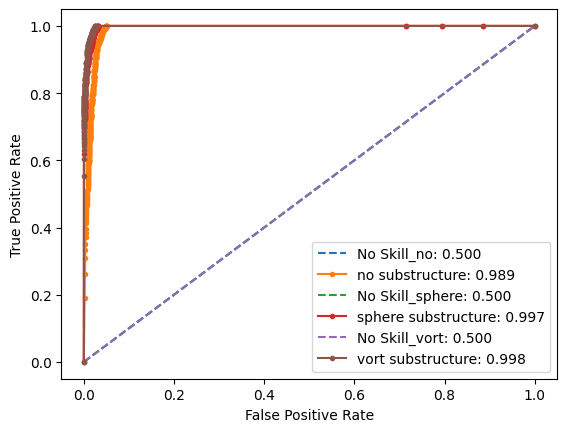

Correct identifications: 0.9248
True had least prob: 0.016266666666666665
True had 2nd highest prob: 0.05893333333333333
Sum for verification = 1.0


In [2]:
# ns_probs = np.array([[1/len(probs[0]) for __ in range(len(probs[0]))] for _ in range(len(preds))])
# # print(probs.shape, ns_probs.shape)
# ns_auc = roc_auc_score(ys, ns_probs,multi_class='ovr')
# lr_auc = roc_auc_score(ys, probs,multi_class='ovr')
# summarize scores
# print('No Skill: ROC AUC=%.3f' % (ns_auc))
# print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
# print(y)
# print(preds)
ns_curves = []
lr_curves = []
aucs = []
print(len(probs))
for i in range(len(test_dataset.classes)):
    y_ = []
    probs_ = []
    for j in range(len(preds)):
        if i==ys[j] and ys[j]==preds[j]:
            # correct classification 1,1
            y_.append(1)
        else: y_.append(0)
        probs_.append(probs[j][i])
    ns_probs = np.array([1/len(probs_) for __ in range(len(probs_))])
    ns_auc = roc_auc_score(y_, ns_probs,multi_class='ovr')
    lr_auc = roc_auc_score(y_, probs_,multi_class='ovr')
    aucs.append((ns_auc,lr_auc))

    ns_fpr, ns_tpr, _ = roc_curve(y_, np.array([0 for i in range(len(y_))]))
    lr_fpr, lr_tpr, _ = roc_curve(y_, probs_)
    ns_curves.append((ns_fpr, ns_tpr))
    lr_curves.append((lr_fpr, lr_tpr))
# plot the roc curve for the model
for i in range(len(test_dataset.classes)):
    plt.plot(ns_curves[i][0], ns_curves[i][1], linestyle='--', label='No Skill_%s: %.3f'%(classes[i],aucs[i][0]))
    plt.plot(lr_curves[i][0], lr_curves[i][1], marker='.', label='%s substructure: %.3f'%(classes[i],aucs[i][1]))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print("Correct identifications: %s\nTrue had least prob: %s\nTrue had 2nd highest prob: %s\nSum for verification = %s"%(best_case/len(ys),worst_case/len(ys),mid_case/len(ys),(best_case+worst_case+mid_case)/len(ys)))

In [3]:
print(len(test_dataset))

7500
